In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import seaborn as sns

from scipy.spatial.distance import cdist

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score, confusion_matrix, accuracy_score

# Part 1: Data Exploration 
- Load the provided data (Assignment5_Data.csv) and examine the first few rows 
- Using StandardScaler(), fit and transform the data 
- Create the scatterplot with surrounding density plots shown in the live session 
  - Tip: Review the code shared after session 8 for reference 
- In a Markdown cell: 
  - Estimate the number of clusters from the scatter and density plots 
  - Also, note any potential issues observed in the data 
    - For example, for the clusters observed, are the cluster densities consistent? 
    - Discuss any regions of overlap 

In [2]:
df = pd.read_csv('Assignment5_Data.csv')

df.head()

,x1,x2
0,-2.505828,4.231421
1,-2.015031,2.577902
2,-0.778732,3.736001
3,-1.525042,2.950457
4,-0.619687,2.703252


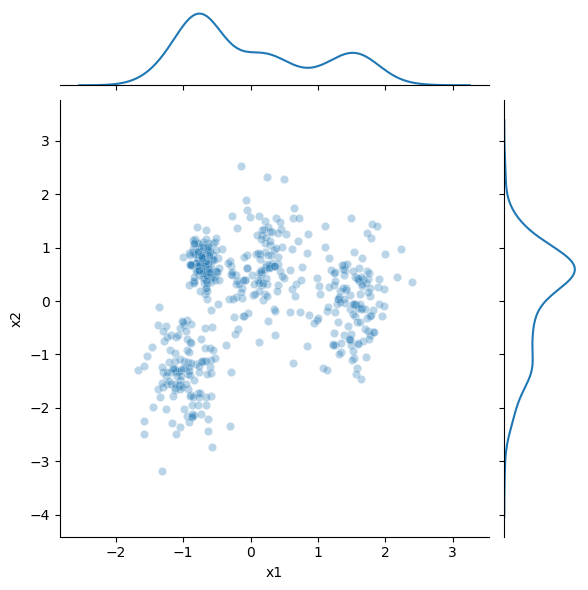

In [3]:
# scale
X = df

std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(X), columns= X.columns)

# plot
g = sns.JointGrid(data=X_scaled, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.3)
g.plot_marginals(sns.kdeplot)
plt.show()

Based on the plot, it the data points look to have a clustering of about 3. Each cluster does not seem to have a similar distrubition of densities and many data points between the visual clusters do seem to overlap around the periphery of each "centroid". Because of the overlap and the difference in point distributions, you can argue that there may even be 4 clusters on this visual bases. With this observation in mind, it may pose a difficulty in being able to correctly identify and cluster the sample data.

# Part 2: K-Means
- Estimate the optimum number of clusters present in the dataset using the following methods: 
    - Elbow Method 
    - Silhouette Score 
    - Davies-Bouldin Score 
- Show a graph of each of the methods in Part 2a versus the number of clusters 
- In a Markdown cell, document the optimum number of clusters found from each method, 
and the number you selected and why 
- Fit a K-Means clusterer with the optimal k value selected in Part 2c 
This represents the best version of a K-Means clusterer for the data


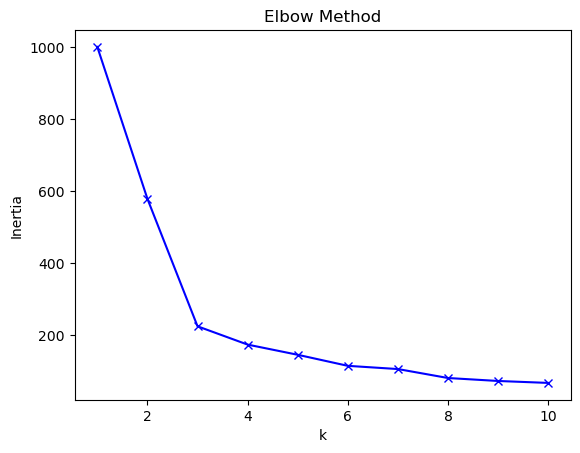

In [4]:
# elbow method

inertias = []
K = range(1, 11)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=432)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

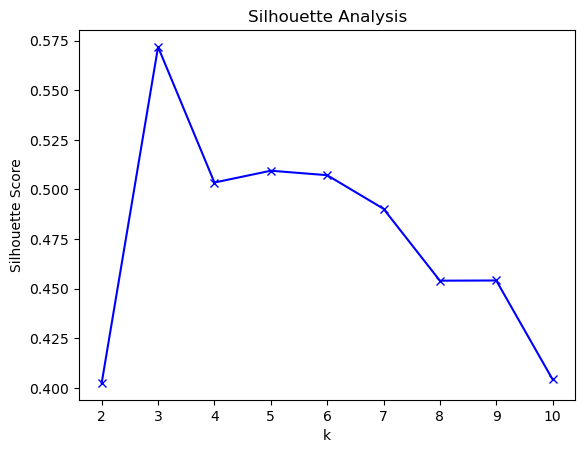

In [5]:
# silhouette

silhouette_scores = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=432)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

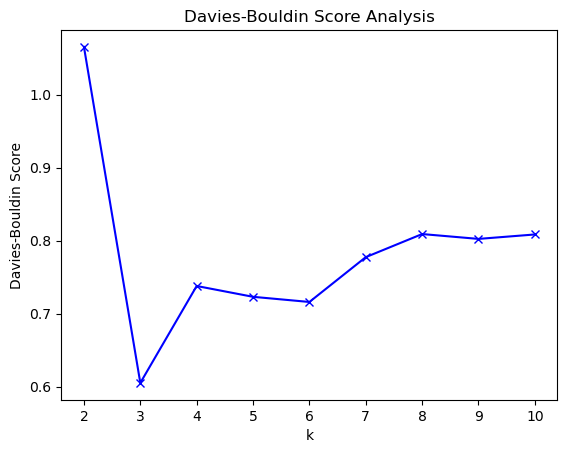

In [6]:
# davies-bouldin

db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=432)
    kmeans.fit(X_scaled)
    score = davies_bouldin_score(X_scaled, kmeans.labels_)
    db_scores.append(score)

plt.plot(range(2, 11), db_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score Analysis')
plt.show()

### Optimal Clusters?

- Elbow: 3
- Silhouette: 4
- Davies-Bouldin: 4


On first inspection visually, the clusters looked to be 3. I documented the argument for 4 due to regions of overlap and inconsitencies with the densisties of the data points. Looking at the cluster optimization through a quantitative lense, we see that 2/3 of the results (Silhouette & Davies-Bouldin) show that there are optimally 4 clusters while only the Elbow method was the only to result in 3. 

Given the quantitative approach and the caveat of the potential shortcoming of visial assessment due to the nature of the data, I will move forward with __4 clusters__. 

__ANS: 4__

In [7]:
# kmeans on cluster = 4
kmeans = KMeans(n_clusters=4, random_state=432)
kmeans.fit(X_scaled)

# get lables/centroids
kmeans_cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

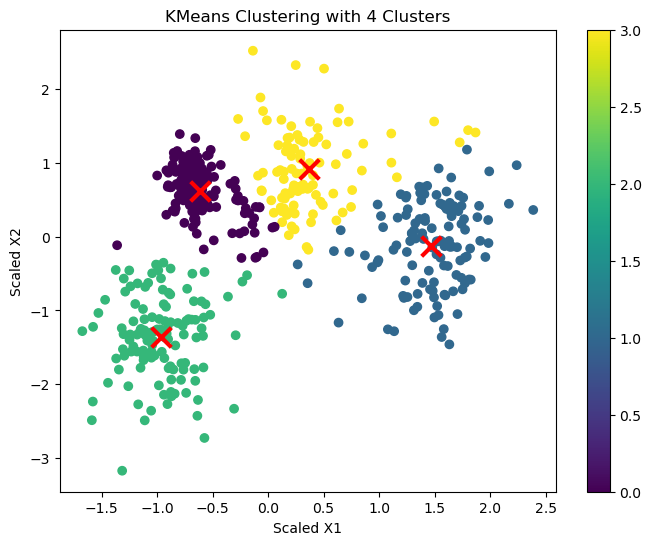

In [8]:
# plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=kmeans_cluster_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.title('KMeans Clustering with 4 Clusters')
plt.xlabel('Scaled X1')
plt.ylabel('Scaled X2')
plt.colorbar(scatter)
plt.show()

# Part 3: Gaussian Mixture Model 
- Estimate the optimal number of clusters from AIC/BIC calculations included within the 
GaussianMixture method. 
- Show a graph of AIC and BIC from Part 3a versus the number of clusters. 
- In a Markdown cell, document the optimum number of clusters 
- Fit a Gaussian Mixture Model with the optimal k value selected 
This represents the best version of a Gaussian Mixture Model for the data

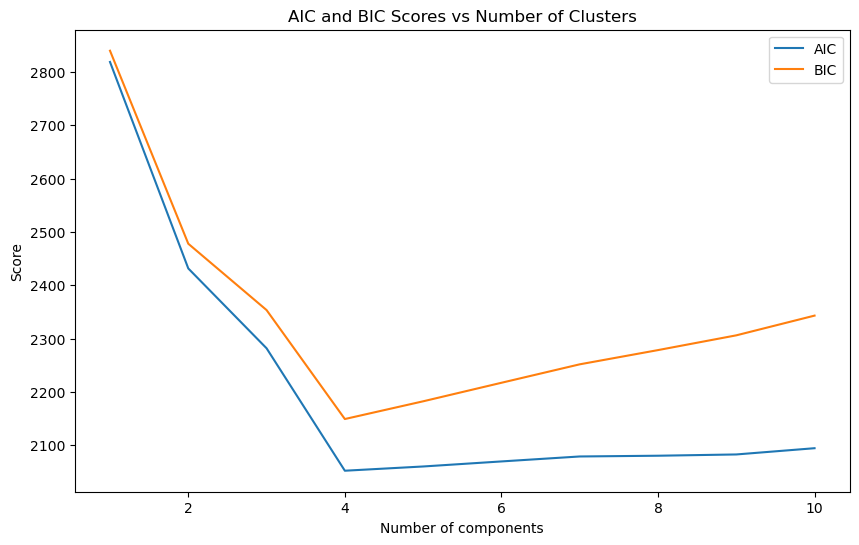

In [9]:
# optimal clusters via AIC (alkaline information criterion) / BIC (bayesian information criterion)

# clusters
n_clusters = range(1, 11) 

# AIC and BIC scores
aic_scores = []
bic_scores = []

# calc AIC and BIC for each number of clusters
for n_components in n_clusters:
    gmm = GaussianMixture(n_components=n_components, random_state=432)
    gmm.fit(X_scaled)
    aic_scores.append(gmm.aic(X_scaled))
    bic_scores.append(gmm.bic(X_scaled))

# plot
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, aic_scores, label='AIC')
plt.plot(n_clusters, bic_scores, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC Scores vs Number of Clusters')
plt.show()

# optimal number of clusters
n_optimal_clusters_aic = n_clusters[np.argmin(aic_scores)]
n_optimal_clusters_bic = n_clusters[np.argmin(bic_scores)]

Based on both the AIC and BIC scores, the optimal number of clusters is __4__. This is an agreement with the previous conclusion on the optimal amount of clusters found in part 2a.

__ANS: 4__

In [10]:
# fit the optimal Gaussian Mixture Mode
optimal_n_clusters = n_optimal_clusters_aic

optimal_gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=432)
optimal_gmm.fit(X_scaled)

# get cluster assignments
gmm_cluster_labels = optimal_gmm.predict(X_scaled)

print(f"\nFitted Gaussian Mixture Model with {optimal_n_clusters} components")


Fitted Gaussian Mixture Model with 4 components


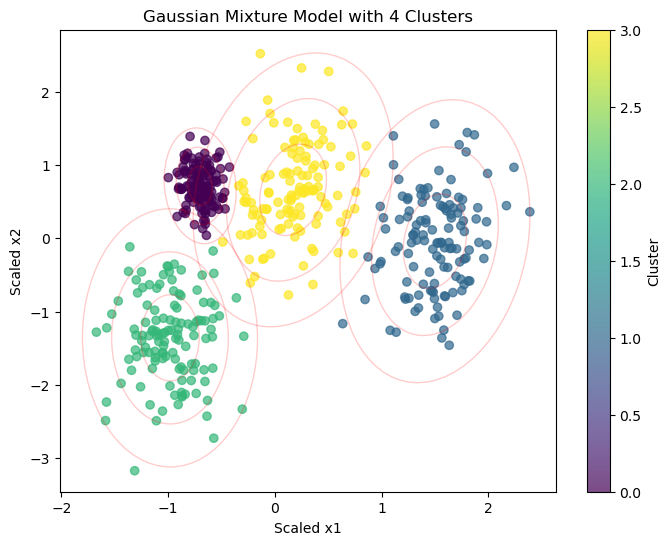

In [11]:

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))


# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=gmm_cluster_labels, cmap='viridis', alpha=0.7)

# Plot Gaussian ellipses
w_factor = 0.2 / optimal_gmm.weights_.max()
for pos, covar, w in zip(optimal_gmm.means_, optimal_gmm.covariances_, optimal_gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor, facecolor='none', edgecolor='r')

plt.title(f'Gaussian Mixture Model with {optimal_n_clusters} Clusters')
plt.xlabel('Scaled x1')
plt.ylabel('Scaled x2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Part 4: DBSCAN 
- Knowing the number of dimensions in the dataset, select the appropriate values for 
min_samples 
- With this value of min_samples, identify the optimal value of epsilon, the distance criteria 
  - Hint:  Review the code shared from live session 9 
- Fit a DBSCAN clusterer with these hyperparameters. 
- Create a plot of data set color coded by the cluster labels form Part 5c. 
- The outliers (labels_ = -1) are problematic to evaluation. 
  - Copy the scaled data set into a new data set named dbscan_df 
  - Add a new column to dbscan_df for the labels predicted from the best DBSCAN 
clusterer in Part 5c 
  - Remove all rows with these labels = -1 
  - Show a graph of dbscan_df color coded by cluster labels. 
  - In a Markdown cell:  
  - Compare the graphs created in Part 5d and 5e(iv) and discuss whether you should 
adjust the distance hyperparameter epsilon.

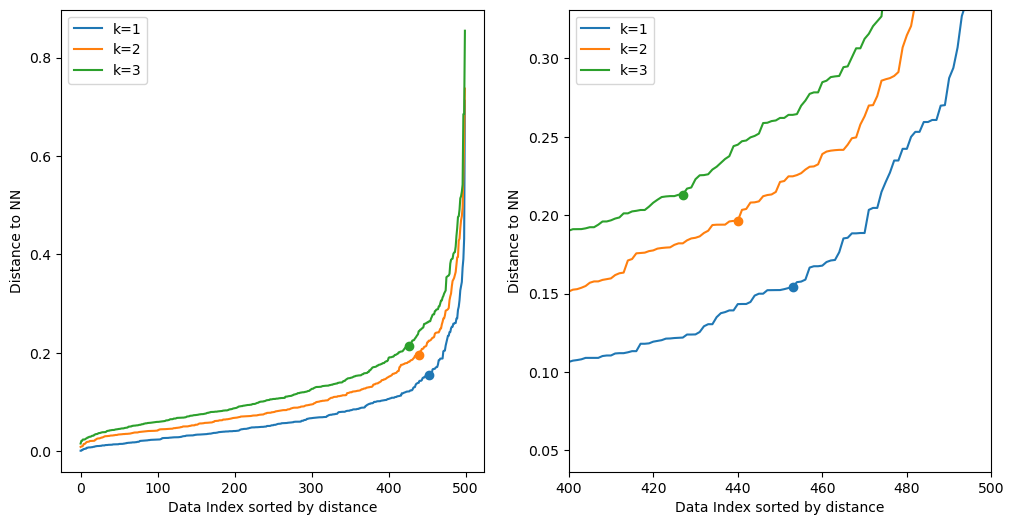

In [12]:
neighbors = 4
nbrs = NearestNeighbors(n_neighbors= neighbors).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

opt_esp_minpts = np.empty((0, 3))
fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, figsize= (12, 6))
for n in np.arange(1, neighbors):
    
    temp_distances = np.sort(distances[:, n])

    lndf = np.linspace(start= 0, stop= 1, num= int(temp_distances.shape[0]))
    scaled_dist = (temp_distances - temp_distances.min()) / (temp_distances.max() - temp_distances.min())
    
    distA = np.concatenate([lndf, scaled_dist]).reshape(2, -1).T
    distB = np.concatenate([lndf, lndf]).reshape(2, -1).T
    
    all2all = cdist(XA = distA, XB= distB)
    idx_opt = all2all.min(axis= 1).argmax()
    
    opt_esp_minpts = np.vstack([opt_esp_minpts, np.array([n, idx_opt, temp_distances[idx_opt]])]) 
    
    ax1.plot(temp_distances, label= f'k={n}')
    ax1.scatter(x= idx_opt, y= temp_distances[idx_opt])
    
    ax2.plot(temp_distances, label= f'k={n}')
    ax2.scatter(x= idx_opt, y= temp_distances[idx_opt])
    
    
eps_delta = opt_esp_minpts[:, 2].max() - opt_esp_minpts[:, 2].min()

ax2.set_xlim([np.floor(opt_esp_minpts[:, 1].min() / 100) * 100, 
              int(temp_distances.shape[0])])
ax2.set_ylim([opt_esp_minpts[:, 2].min() - 2*eps_delta,
              opt_esp_minpts[:, 2].max() + 2*eps_delta])    
ax1.legend()
ax1.set_xlabel('Data Index sorted by distance')
ax1.set_ylabel('Distance to NN')
ax2.legend()
ax2.set_xlabel('Data Index sorted by distance')
ax2.set_ylabel('Distance to NN')


plt.show()


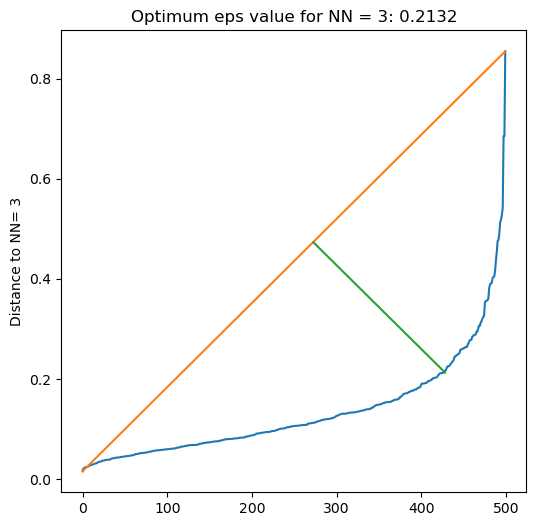

In [13]:
temp_distances = np.sort(distances[:, 3])
line_coords = np.vstack([distA[idx_opt], distB[all2all[idx_opt].argmin()]])
line_coords[:, 0] = line_coords[:, 0] * X.shape[0]
line_coords[:, 1] = line_coords[:, 1] * (temp_distances.max() - temp_distances.min()) + temp_distances.min()

plt.figure(figsize= (6, 6))
plt.plot(temp_distances)
plt.plot(np.linspace(start= temp_distances.min(), stop= temp_distances.max(), num= int(temp_distances.shape[0])))
plt.plot(line_coords[:, 0],
         line_coords[:, 1])
plt.ylabel(f'Distance to NN= {int(opt_esp_minpts[-1, 0])}')
plt.title(f'Optimum eps value for NN = {int(opt_esp_minpts[-1, 0])}: {np.round(opt_esp_minpts[-1, 2], 4)}')
plt.show()

Based on this plot(s), the elbow (where the curve starts to level off) looks to be around 0.20. Quantitatively, we get 0.21. In addition, the min_points used is from common convention where min_points = 2*num_features.

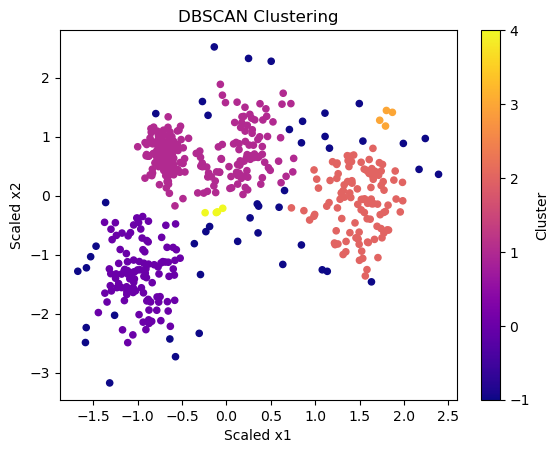

In [14]:
# train dbscan w/ epsilon = 0.21 and minpoints = 4

epsilon = 0.21

# feature dims
min_points = 2 * X.shape[1]

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
dbscan_cluster_labels = dbscan.fit_predict(X_scaled)

# Plot the clusters
scatter = plt.scatter(X_scaled.iloc[:, 0], X_scaled.iloc[:, 1], c=dbscan_cluster_labels, cmap='plasma', s=20)
plt.xlabel('Scaled x1')
plt.ylabel('Scaled x2')
plt.title('DBSCAN Clustering')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [15]:
# create copy + add dbscan_cluster_labels
dbscan_df = X_scaled.copy()
dbscan_df['predicted_l1'] = dbscan_cluster_labels

# drop rows where dbscan_cluster_labels == -1
dbscan_df = dbscan_df.loc[dbscan_df['predicted_l1'] != -1]

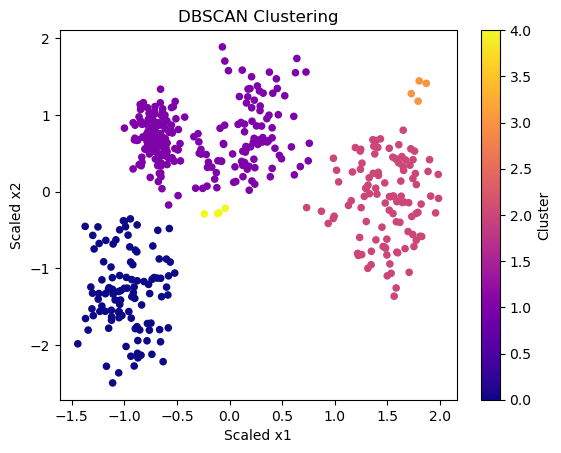

In [16]:
# new clustering after removing -1 labels

# Plot the clusters
scatter = plt.scatter(dbscan_df.iloc[:, 0], dbscan_df.iloc[:, 1], c=dbscan_df['predicted_l1'], cmap='plasma', s=20)
plt.xlabel('Scaled x1')
plt.ylabel('Scaled x2')
plt.title('DBSCAN Clustering')
plt.colorbar(scatter, label='Cluster')
plt.show()

In part 4D (with -1 lables included), we get 3 core clusters, 2 smaller peripheral clusters, and many outliers (-1). With the outliers, the final clustering contains a lot of noise. In part 4E(iv), we remove the outliers. This gets rid of the noise and reveals the core 3 clusters alping with smaller 2 peripheral clusters.

Based on the work that was done in finding the optimal amount of clusters via the elbow method, silhouette analysis, the davies-bouldin score and then clustering with K-Means/Gausian Mixture Model, the optimal number of clusters should be 4. Therefore, the current distance hyperparameter, epsilon, may need to be adjusted. Based on epsilon's relationship with the number of clusters generated, we may have to decrease it to find more clusters via dbscan. 

# Part 5: Model Evaluation

- You have three optimized clustering methods:  K-Means, Gaussian Mixture Model, and 
DBSCAN 
- Construct plots of each clustering method's label predictions 
  - Hint:  plt.subplots(nrows= 1, ncols= 4) and Seaborn scatterplot are really helpful.   

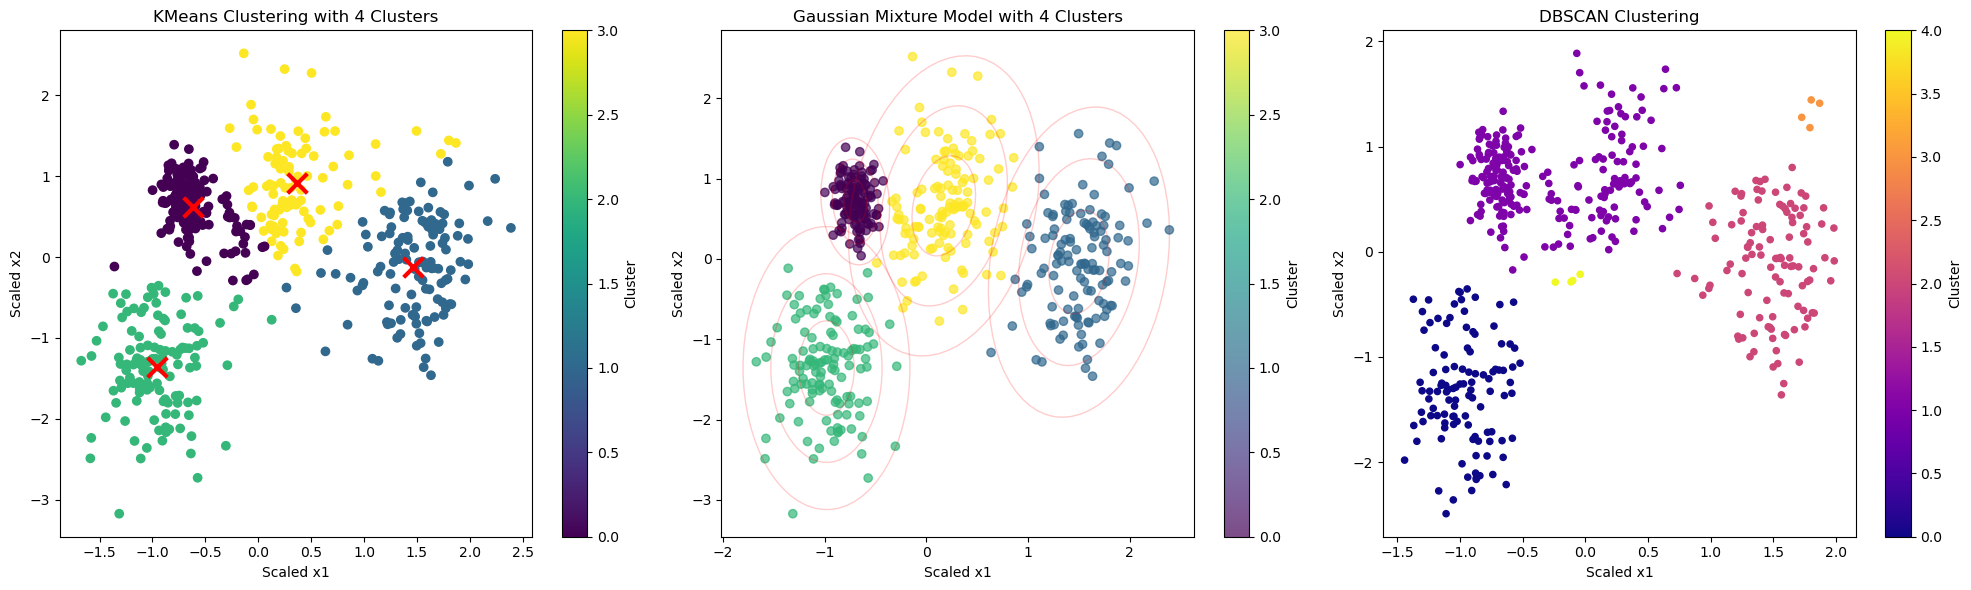

In [17]:
# create the subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# constants
X_LABEL = 'Scaled x1'
Y_LABEL = 'Scaled x2'
X1 = X_scaled.iloc[:, 0]
X2 = X_scaled.iloc[:, 1]
COLORBAR_LABEL = 'Cluster'

# KMeans plot
scatter_kmeans = axs[0].scatter(X1, X2, c=kmeans_cluster_labels, cmap='viridis')
axs[0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
axs[0].set_title('KMeans Clustering with 4 Clusters')
axs[0].set_xlabel(X_LABEL)
axs[0].set_ylabel(Y_LABEL)
fig.colorbar(scatter_kmeans, ax=axs[0], label=COLORBAR_LABEL)

# GMM plot
scatter_gmm = axs[1].scatter(X1, X2, c=gmm_cluster_labels, cmap='viridis', alpha=0.7)

w_factor = 0.2 / optimal_gmm.weights_.max()
for pos, covar, w in zip(optimal_gmm.means_, optimal_gmm.covariances_, optimal_gmm.weights_):
    draw_ellipse(pos, covar, ax=axs[1], alpha=w * w_factor, facecolor='none', edgecolor='r')

axs[1].set_title(f'Gaussian Mixture Model with {optimal_n_clusters} Clusters')
axs[1].set_xlabel(X_LABEL)
axs[1].set_ylabel(Y_LABEL)
fig.colorbar(scatter_gmm, ax=axs[1], label=COLORBAR_LABEL)

# DBSCAN plot
scatter_dbscan = axs[2].scatter(dbscan_df.iloc[:, 0], dbscan_df.iloc[:, 1], c=dbscan_df['predicted_l1'], cmap='plasma', s=20)
axs[2].set_xlabel(X_LABEL)
axs[2].set_ylabel(Y_LABEL)
axs[2].set_title('DBSCAN Clustering')
fig.colorbar(scatter_dbscan, ax=axs[2], label=COLORBAR_LABEL)

plt.tight_layout()
plt.show()

### Questions (clustering):
  - Visually inspect the plots in Part 5b.  Which method produced the best clustering of the 
data and why? 
  - Also, document the similarities in the clusters identified by the different methods. 
  - Finally, how do you agree with your observations of densities and overlap discussed in 
Question 1? 

Off the bat, DBSCAN produced 5 total clusters, with 3 core clusters, and could not cluster many outlier data points. Because of these factors, DBSCAN is the least effective clustering algorithm for this data. For the last two methods, both produced 4 clusters. The centroids/regions of both methods are very simlar in shape and identify nearly the same clusters. However, where they differ is in the bounds of the clusters. In KMeans, there is overlap between the clusters and what looks like to be "spillage" from one to the next. While in GMM, the clusters bounds are more defined with less overlap. Because of the distinct and concrete clustering produced by the Guassian Mixture Model, it looks to have produced the best cluster.

Lastly, from Part 1, I discussed that visually, I saw 3 densitites of clusters with non-similar density distributions. However, after going through this clustering analysis, it looks like my inital observations are not in agreement with these final results. Based off the different clustering methods used, there are 4 clusters with fairly similar density distributions.


In [18]:
# Gather or calculate the Silhouette Score and Davies-Bouldin Score for each of the three clusterings.  
# Tip: Be cautious with DBSCAN calculations due to outliers. Use dbscan_df from Part 4e for these calculations 

# KMeans
kmeans_silhouette = silhouette_score(X_scaled, kmeans_cluster_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_cluster_labels)

# GMM
gmm_silhouette = silhouette_score(X_scaled, gmm_cluster_labels)
gmm_db = davies_bouldin_score(X_scaled, gmm_cluster_labels)

# DBSCAN
dbscan_silhouette = silhouette_score(dbscan_df[['x1', 'x2']], dbscan_df['predicted_l1'])
dbscan_db = davies_bouldin_score(dbscan_df[['x1', 'x2']], dbscan_df['predicted_l1'])

print("KMeans: \nSilhouette Score: {:.4f}\nDavies-Bouldin Score: {:.4f}".format(kmeans_silhouette, kmeans_db))
print("\nGMM: \nSilhouette Score: {:.4f}\nDavies-Bouldin Score: {:.4f}".format(gmm_silhouette, gmm_db))
print("\nDBSCAN: \nSilhouette Score: {:.4f}\nDavies-Bouldin Score: {:.4f}".format(dbscan_silhouette, dbscan_db))

KMeans: 
Silhouette Score: 0.5035
Davies-Bouldin Score: 0.7380

GMM: 
Silhouette Score: 0.4898
Davies-Bouldin Score: 0.7851

DBSCAN: 
Silhouette Score: 0.3654
Davies-Bouldin Score: 0.5386


### Final Questions (metrics)
- Which method performed best per metric? 
- Do you agree with the metric values assessment? 
- One clusterer optimized Silhouette and another clusterer optimized Davies-Bouldin 
score. Why the disagreement between scoring metrics?

For the Silhouette score, the best performing model was K-Means (highest score). For the Davies-Bouldin score, the best performing model was DBSCAN (lowest score). Interestingly, the model that performed in the middle for both metrics was GMM and that was the model that I thought performed the best clustering of the data. 

I think this speaks to the importance of understanding what an evaluation metric is and what it's actually measuring. The silhouette score optimizes for how similar a single data point is to its own cluster versus others (via distance). Essentially, it is a measure of how well a data point fits in its cluster. In addition to this, this metric assumes that clusters are linearly seperable and spherical in shape. K-Means with it's iterative approach to minimizing points' distance to a centroid, optimizes for highly seperated and spherical clusters. This type of clustering is optimizing for what the silhouette score is essentially measuring for. This explains why K-Means performed the best for this metric.

On the other hand, the Davies-bouldin score focuses on the ratio of "within-cluster" distances to "between-cluster" distances. This essentially measures how compact and well-separated the clusters are from each other. In DBSCAN, it it density-based, can create natural/arbitrary cluster shapes, and does not have pre-defined amounts of clusters. This allows for the optimization of smaller, well-seperated, compact, and numerous clusters to be found. This type of clustering is what Davies-boulding optimizes for which again, is why DBSCAN performed the best for this metric. 

Going back to what I thought was the best clustering alorithm, it was GMM due to it's distinct and well-seperated clustering in comparison to the K-Means/DBSCAN clusters. While GMM did not optimize for the Silhouette score or the Davies-Bouldin score and did not get the best scores, it performed very well. Knowing how the two evaluation metrics work, it makes sense why GMM came out on top. In the case of this data, GMM was a good middle ground of being able to create spherical, compact clusters that were well-seperated. 

Again, it highlights the importance of knowing what an evaluation metric assumes, how it works, and what it optimzes for. Simply getting a "good" metric is completely arbitrary if you don't know what you are measuring againt. In this case, the best clusterer was the one that did not optimze for either. 

Having said all of this, I do personally agree with the metric values assessment although they do not correctly attribute to the best clusterer. This is becuase I am using these metrics more so as an observation of clustering characteristics rather than a full-on performance evaluation. In one perspective, the metrics are wrong, but in another, there is a more nuanced interpretation.